In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
!pip install split-folders

In [125]:

#Import necessary packages

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
from keras.utils import np_utils
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import splitfolders
import cv2
import os
tfd = tfp.distributions
tfpl = tfp.layers
%matplotlib inline

In [137]:
# We will split our data into train and test sets

source= os.path.join('/content/drive/MyDrive/fire_dataset')
destination= os.path.join('/content/drive/MyDrive/train_test_splitted/')

# We will split and allocate the folders

splitfolders.ratio(door, room, seed=0000, ratio=(0.9,0.1), group_prefix= None)

Copying files: 1228 files [04:43,  4.32 files/s]


In [138]:
train_dir = os.path.join('/content/drive/MyDrive/train_test_splitted/train')
test_dir = os.path.join('/content/drive/MyDrive/train_test_splitted/val')

In [148]:
def loader_image(train_parent_directory, test_parent_directory):
    
    train_datagen = ImageDataGenerator(rescale=1./255,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True
                                       )
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    train_dataset = train_datagen.flow_from_directory(train_parent_directory,
                                  target_size = (80,80),
                                  batch_size = 50,
                                  class_mode = 'categorical')
 
    
    validation_dataset = validation_datagen.flow_from_directory(test_parent_directory,
                                 target_size=(80,80),
                                 batch_size = 30,
                                 class_mode = 'categorical')    
    
    return train_dataset, validation_dataset

In [149]:
train_dataset, validation_dataset = loader_image(train_dir, test_dir)

Found 1104 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


In [150]:
# ... just to check the classes

print(train_dataset.class_indices, test_dataset.class_indices)


{'fire_images': 0, 'non_fire_images': 1} {'fire_images': 0, 'non_fire_images': 1}


In [151]:
# number of files belonging to the train set

list_1 = os.listdir(train_dir +'/fire_images') # dir is your directory path
list_2 = os.listdir(train_dir +"/non_fire_images") # dir is your directory path

number_files = len(list_1)+len(list_2)
number_files

1104

In [152]:
def nll(y_true, y_pred):
    """
    This function should return the negative log-likelihood of each sample
    in y_true given the predicted distribution y_pred. If y_true is of shape 
    [B, E] and y_pred has batch shape [B] and event_shape [E], the output 
    should be a Tensor of shape [B].
    """
    #y_true = tf.placeholder(tf.float32,shape=[None,])
    return -y_pred.log_prob(y_true)

In [153]:
kl_divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/number_files

In [160]:
def bayesian_convolutional_model(input_shape, divergence_function, loss, optimizer, metrics):

    bcnn_model = Sequential([
                            # Convolutional reparameterization layers
                            tfpl.Convolution2DReparameterization(
                                      input_shape=input_shape, filters=8, 
                                      kernel_size=16, activation='relu', padding='SAME',
                                      #Kernel details
                                      kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                      kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                      kernel_divergence_fn = divergence_function,
                                      #Bias details
                                      bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                      bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                      bias_posterior_tensor_fn=(lambda d: d.sample()),
                                      bias_divergence_fn = divergence_function),
                              # Additional layers
                            MaxPooling2D(2,2),
                            Conv2D(32, 4, activation='relu'),
                            MaxPooling2D(2,2),
                            Conv2D(64, 4, activation='relu'),
                            Dropout(0.15),
                            MaxPooling2D(2,2),
                            Conv2D(64, 4, activation='relu'),
                            Dropout(0.35),
                            MaxPooling2D(2,2),
                            Flatten(),
                            Dense(416, activation='relu'),
                            # Dense reparameterizational layers
                            tfpl.DenseReparameterization(
                                      units=tfpl.OneHotCategorical.params_size(2), activation=None,
                                      #Kernel details
                                      kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                      kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                      kernel_posterior_tensor_fn=(lambda d: d.sample()),
                                      kernel_divergence_fn = divergence_function,
                                      #Bias details
                                      bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                      bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                      bias_posterior_tensor_fn=(lambda d: d.sample()),
                                      bias_divergence_fn = divergence_function
                                    ),
        tfpl.OneHotCategorical(2,convert_to_tensor_fn=tfd.Distribution.mode)
        
    ])
    bcnn_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return bcnn_model

In [161]:
bayesian_cnn_model=bayesian_convolutional_model(
                                        input_shape=(80,80,3),
                                        divergence_function=kl_divergence_fn,
                                        loss = nll,
                                        optimizer = Adam(learning_rate=0.001),
                                        metrics = ['accuracy']
                                        )

bayesian_cnn_model.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_5  (None, 80, 80, 8)         12304     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 40, 40, 8)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 37, 37, 32)        4128      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 64)        32832     
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 15, 64)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 64)         

In [162]:
history_bayes = bayesian_cnn_model.fit(
      train_dataset,
      validation_data=validation_dataset,
      epochs=20,
      verbose=1)

Epoch 1/20
23/23 [==============================] - 59s 2s/step - loss: 16.8066 - accuracy: 0.5866 - val_loss: 16.5841 - val_accuracy: 0.5887
Epoch 2/20
23/23 [==============================] - 59s 3s/step - loss: 16.4327 - accuracy: 0.7020 - val_loss: 16.3286 - val_accuracy: 0.7419
Epoch 3/20
23/23 [==============================] - 56s 2s/step - loss: 16.3211 - accuracy: 0.7850 - val_loss: 16.1750 - val_accuracy: 0.6935
Epoch 4/20
23/23 [==============================] - 56s 2s/step - loss: 16.4496 - accuracy: 0.7282 - val_loss: 16.0387 - val_accuracy: 0.8226
Epoch 5/20
23/23 [==============================] - 56s 2s/step - loss: 16.0152 - accuracy: 0.8162 - val_loss: 15.9930 - val_accuracy: 0.7177
Epoch 6/20
23/23 [==============================] - 56s 2s/step - loss: 15.9274 - accuracy: 0.7868 - val_loss: 15.9062 - val_accuracy: 0.8468
Epoch 7/20
23/23 [==============================] - 56s 2s/step - loss: 15.7731 - accuracy: 0.8743 - val_loss: 15.6777 - val_accuracy: 0.9194
Epoch 

In [208]:

def import_and_predict_bayes(image,model, true_label):

    #read image
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    img_resize = (cv2.resize(img, dsize=(80, 80), interpolation=cv2.INTER_AREA))/255.
    
    predicted_probabilities = np.empty(shape=(500, 2))
    
    for i in range(500):
        
        predicted_probabilities[i] = model(img_resize[np.newaxis,...]).mean().numpy()[0]

    fig,ax=plt.subplots(nrows=1, ncols=2,figsize=(6,4))

    #show the image
    ax[0].imshow(img)
    ax[0].axis('off')
        
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(2)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(2)])
    
    #fig, ax = plt.subplots(figsize=(10, 6))
    bar = ax[1].bar([0,1], pct_97p5, color='red')
    bar[true_label].set_color('green')
    ax[1].bar([0,1], pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax[1].set_xticks([0,1])
    ax[1].set_xlim("fire_images", "non_fire_images")
    ax[1].set_ylim([0, 1])
    ax[1].set_ylabel('Probability')
    _=plt.show()

In [209]:
label = os.listdir(test_dir)
image_dir_1 = os.path.join('/content/drive/MyDrive/Fire/fire.135.png')


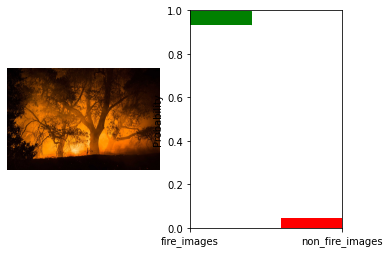

In [210]:
import_and_predict_bayes(image_dir_1,bayesian_cnn_model, label.index('fire_images'))

array([0, 1])

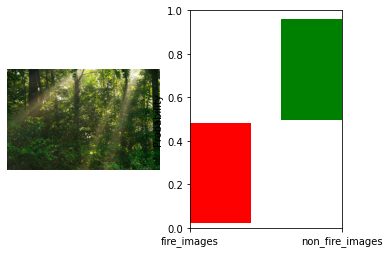

In [211]:
pimage_dir_2=os.path.join('/content/drive/MyDrive/fire_dataset/non_fire_images/non_fire.220.png')
import_and_predict_bayes(image_dir_2,bayesian_cnn_model, label.index('non_fire_images'))

Plot of the loss and accuracy of the model:

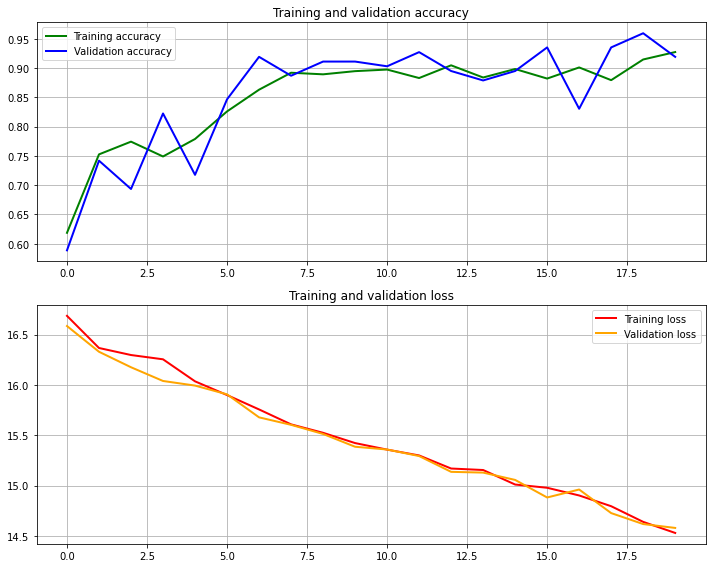

In [174]:

acc = history_bayes.history['accuracy']
val_acc = history_bayes.history['val_accuracy']
loss = history_bayes.history['loss']
val_loss = history_bayes.history['val_loss']

epochs = range(len(acc))

# Plot the accuracy and loss
fig, ax = plt.subplots(2, figsize=(10,8))

# accuracy
ax[0].grid()
ax[0].plot(epochs, acc, 'g',linewidth=2, label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b',linewidth=2, label='Validation accuracy')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

# Loss
ax[1].grid()
ax[1].plot(epochs, loss, 'r',linewidth=2, label='Training loss')
ax[1].plot(epochs, val_loss, 'orange',linewidth=2, label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()
_=fig.tight_layout()



#Hyper Parameter Tuning:

In [94]:
!pip install keras-tuner

In [95]:
import kerastuner as kt

In [111]:
# function for searching best suited hyper parameter
def tuning_model(hp):
  cnn_model=Sequential([
                        # Dense reparameterizational layers
                        tfpl.Convolution2DReparameterization(
                                filters=8,
                                kernel_size=hp.Choice('1st_layer_kernel_size', values=[2,4,6,8,10,12,14,16,18,20]),
                                input_shape=(80,80,3), padding='SAME',
                                activation=hp.Choice('1st_layer_activation',values=['relu', 'tanh', 'sigmoid']),
                                #Kernel details
                                kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                kernel_divergence_fn = kl_divergence_fn,
                                #Bias details
                                bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                bias_posterior_tensor_fn=(lambda d: d.sample()),
                                bias_divergence_fn = kl_divergence_fn),
                        
                        # Additional layers
                            MaxPooling2D(2,2),
                            Conv2D(32,4),
                            Dropout(rate=hp.Float(
                                      'dropout_3',
                                      min_value=0.0,
                                      max_value=0.5,
                                      default=0.25,
                                      step=0.05)
                                    ),
                            MaxPooling2D(2,2),
                            Conv2D(64, 4),
                            MaxPooling2D(2,2),
                            Conv2D(64, 4),
                            Dropout(rate=hp.Float(
                                      'dropout_3',
                                      min_value=0.0,
                                      max_value=0.5,
                                      default=0.25,
                                      step=0.05)
                                    ),
                            MaxPooling2D(2,2),
                            Flatten(),
                            Dense(
                                hp.Int('Dense_units', min_value=32, max_value=512, step=64)
                                 ),
                        
                            # Dense reparameterizational layers
                            tfpl.DenseReparameterization(
                                units=tfpl.OneHotCategorical.params_size(2), activation=None,
                                #Kernel details
                                kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                kernel_posterior_tensor_fn=(lambda d: d.sample()),
                                kernel_divergence_fn = kl_divergence_fn,
                                #Bias details
                                bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                bias_posterior_tensor_fn=(lambda d: d.sample()),
                                bias_divergence_fn = kl_divergence_fn),
        tfpl.OneHotCategorical(2,convert_to_tensor_fn=tfd.Distribution.mode)
        ])
  cnn_model.compile(
              optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss=nll,
              metrics=['accuracy'])
  
  return cnn_model

In [112]:
from kerastuner import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters

In [113]:
tuned_sets=BayesianOptimization(tuning_model,
                                objective = 'val_accuracy', 
                                max_trials = 5,
                                directory='/content/drive/MyDrive/',
                                project_name='Hypertuned_BayesianCNN_for_fire_detection'
                               )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [114]:
tuned_sets.search(train_dataset, validation_data=validation_dataset,epochs=10)

Trial 5 Complete [00h 12m 11s]
val_accuracy: 0.6290322542190552

Best val_accuracy So Far: 0.9193548560142517
Total elapsed time: 00h 48m 27s
INFO:tensorflow:Oracle triggered exit


In [115]:
best_bayesian_model=tuned_sets.get_best_models(num_models=1)[0]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [116]:
best_bayesian_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization (C (None, 80, 80, 8)         3088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 8)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 37, 37, 32)        4128      
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 64)        0

In [117]:
best_bayesian_model.fit(train_dataset,validation_data=validation_dataset, epochs=20,verbose=1)

Epoch 1/20
23/23 [==============================] - 39s 2s/step - loss: 4.1632 - accuracy: 0.8741 - val_loss: 4.2798 - val_accuracy: 0.8790
Epoch 2/20
23/23 [==============================] - 37s 2s/step - loss: 4.1202 - accuracy: 0.8565 - val_loss: 4.3693 - val_accuracy: 0.7903
Epoch 3/20
23/23 [==============================] - 37s 2s/step - loss: 4.0406 - accuracy: 0.9078 - val_loss: 4.2312 - val_accuracy: 0.8629
Epoch 4/20
23/23 [==============================] - 37s 2s/step - loss: 4.0711 - accuracy: 0.8736 - val_loss: 4.3454 - val_accuracy: 0.8468
Epoch 5/20
23/23 [==============================] - 37s 2s/step - loss: 4.0218 - accuracy: 0.8979 - val_loss: 4.6348 - val_accuracy: 0.7339
Epoch 6/20
23/23 [==============================] - 38s 2s/step - loss: 4.1205 - accuracy: 0.8640 - val_loss: 4.3124 - val_accuracy: 0.8790
Epoch 7/20
23/23 [==============================] - 37s 2s/step - loss: 3.9562 - accuracy: 0.9046 - val_loss: 4.3996 - val_accuracy: 0.7903
Epoch 8/20
23/23 [==

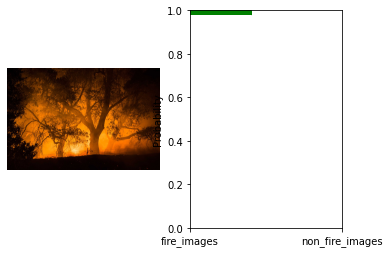

In [212]:
import_and_predict_bayes(image_dir_1,best_bayesian_model, label.index('fire_images'))

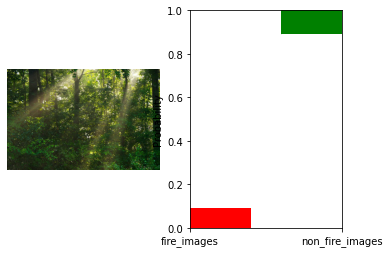

In [214]:
import_and_predict_bayes(image_dir_2,best_bayesian_model, label.index('non_fire_images'))